In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

from scipy.stats import ttest_rel, ttest_1samp

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data

%matplotlib inline

In [2]:
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/ppi')
path_nistats = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats')
path_betamats = os.path.join(path_out, 'betamats')
path_parcellations = os.path.join(path_out, 'parcellations')
path_exclusion_csv = os.path.join(path_nistats, 'exclusion/exclusion.csv')
path_betamats_custom_roi = os.path.join(path_betamats, 'customROI')

# Behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape

# PPI model regressors information
beta_names = ['physio', 'dec_ons', 'dec_wcor', 'res_lbp', 'res_rbp', 
              'ppi_out_ons', 'ppi_out_perr', 'out_ons', 'out_perr', 'out_off',
              'reg_intercept']
n_regressors = len(beta_names)

# ROI information
df_custom = pd.read_csv(
    os.path.join(path_parcellations, 'custom_roi/custom_roi_table.csv'),
    sep=' ')
n_rois = len(df_custom)
n_nets = len(df_custom['netName'].unique())

# Load exclusion table
df_exclusion = pd.read_csv(path_exclusion_csv, index_col=0)
ok_index = df_exclusion.index[df_exclusion['ok_all']]

### Load beta matrices 

- `beta_mats_agg`: beta_matrices (shape `n_regressors` $\times$ `n_rois` $\times$ `n_rois)` aggregated over subjects and tasks)
- `beta_mats_agg_sym`: version with beta weights symmetrized for connections `ij` and `ji` 

In [3]:
beta_idx = beta_names.index('ppi_out_perr')

beta_mats_agg = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
beta_mats_agg_sym = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
nets_mats_agg_sym = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_nets, n_nets))

for sub, sub_name in enumerate(meta['dim1']):
    for con, con_name in enumerate(meta['dim2']):
        
        beta_mats_fname = f'sub-{sub_name}_task-{con_name}_betamats.npy'
        beta_mats = np.load(os.path.join(path_betamats_custom_roi, 
                                         beta_mats_fname))
        
        beta_mats_agg[sub, con] = beta_mats
        beta_mats_agg_sym[sub, con] = beta_mats + np.transpose(beta_mats, 
                                                               (0, 2, 1))
        
for i, net_i in enumerate(df_custom['netName'].unique()):
    for j, net_j in enumerate(df_custom['netName'].unique()):
        net_i_idx = df_custom[df_custom['netName'] == net_i].index
        net_j_idx = df_custom[df_custom['netName'] == net_j].index
        nets_mats_agg_sym[:, :, :, i, j] = np.mean(
            beta_mats_agg_sym[:, :, :, net_i_idx, :][:, :, :, :, net_j_idx], 
            axis=(-1, -2))
        
# Filter excluded subjects
beta_mats_agg = beta_mats_agg[ok_index]
beta_mats_agg_sym = beta_mats_agg_sym[ok_index]
nets_mats_agg_sym = nets_mats_agg_sym[ok_index]
        
print('beta_mats_agg_sym.shape: ', beta_mats_agg_sym.shape)
print('nets_mats_agg_sym.shape: ', nets_mats_agg_sym.shape)

beta_mats_agg_sym.shape:  (29, 2, 11, 14, 14)
nets_mats_agg_sym.shape:  (29, 2, 11, 2, 2)


In [4]:
data = []
for sub, sub_name in enumerate(df_exclusion.loc[ok_index, 'sub']):
    for con, con_name in enumerate(meta['dim2']):
        for net, netidx in {'+pe': (0, 0), '-pe': (1, 1), 'mix': (0, 1)}.items():
            data.append(
                [
                    nets_mats_agg_sym[sub, con, beta_idx, netidx[0], netidx[1]],
                    sub_name,
                    con_name,
                    net
                ]
            )
            
df = pd.DataFrame(data, columns=['beta', 'sub_name', 'con_name', 'net'])

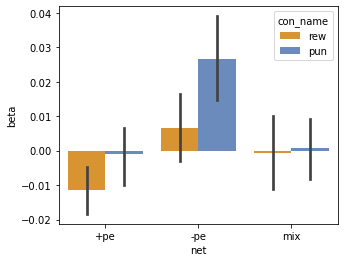

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))
bp = sns.barplot(
    x='net', 
    y='beta', 
    hue='con_name',
    data=df,
    ax=ax,
    palette={'rew': '#f49915', 'pun': '#5E88CA'}
)